# A guide to nested sampling, featuring your particle!
#### by Nathan Simpson (nathan.simpson@hep.lu.se)

*This notebook aims to convey the basic principles behind Bayesian inference. The user creates a hypothetical particle with a particular mass and decay width, then explores some of the ways to discover it using the Bayesian method known as nested sampling.*

## A quick intro to Bayesian methods

Bayesian inference allows you to update your prior beliefs about your model of a thing in light of data about that thing. It is completely based upon Bayes' theorem, which states that for probability distribution $\pi(\cdot)$, data $\textbf{x}$, and model parameters $\mathbf{\theta} = \{ \theta_1, \theta_2, \dots, \theta_n\}$,
\begin{equation}
\pi({\theta}|\textbf{x}) = \frac{\pi(\textbf{x}|{\theta})\pi({\theta})}{\pi(\textbf{x})}\quad.
\end{equation}

The distributions each have their own special name: $\pi({\theta}|\textbf{x})$ is the joint *posterior* distribution of the parameters ${\theta}$, $\pi(\textbf{x}|\mathbf{\theta})$ is known as the *likelihood* $\mathrm{L}({\theta} | \textbf{x})$, $\pi({\theta})$ is the product of the individual distributions $\pi(\theta_i)$ which are the *prior* distributions for each parameter, and the normalising factor $\pi(\textbf{x})$ is the Bayesian *evidence* $Z$, which is obtained by marginalising the unknown parameters over parameter domain $\Omega$, i.e.

\begin{equation}
Z = \int_\Omega \mathrm{L}(\theta|\textbf{x})\times\pi(\theta)\,\mathrm{d}\theta \quad.
\end{equation}
 Often, Bayesian computation only requires proportionality with respect to the parameters, so it's common to just think of the equation

\begin{equation}
    \mathrm{Posterior} \propto \mathrm{Likelihood} \times \mathrm{Priors}
\end{equation}

as the one upon which you build your inference, but this approach neglects the calculation of $Z$, which is an indication of how good your model is. We would prefer to not do this, and instead use a method to calculate $Z$.

## Nested Sampling

In 2006, John Skilling published a paper entitled 'Nested Sampling for General Bayesian Computation', which proposed an alternative to inference techniques that took into account evidences. The nested sampling algorithm works by iteratively sampling from shrinking likelihood contours in the parameter space of interest in order to sample points around areas of high posterior density. This is done by repeatedly sampling from the prior distribution of the parameters and rejecting points that have a lower likelihood than the previous sample. 

![alt text](ns2.png "Nested sampling")


The samples at the current iteration are the 'live' points, whilst the rejected samples are conversely known as 'dead' points. 

Nested sampling calculates evidences by switching integration variable from the parameters $d\theta$ to the so-called *prior mass* $\pi(\theta)\,d\theta = dX$. This is termed as such due to the integral $\int_{\mathrm{L}(\theta|\textbf{x})<\mathrm{L}_i} X dX$ resulting in the fraction of the prior enclosed by the iso-likelihood contour $\mathrm{L}_i$. If one assigns a value of prior mass for each sample, then due to the nature of the algorithm, $\mathrm{L}(X)$ becomes a monotonic function of $X$ by construction. One can then use simple numerical tools to perform the integration, e.g. the trapezium rule.

The output from the algorithm is a weighted set of posterior samples for each parameter using both the live and the dead points, along with the corresponding evidence value for the run as a whole. The weight of a sample point is proportional to its share of the posterior mass.

## Build-a-boson

So you've had a quick introduction in the abstract sense -- now let's get our hands dirty, and apply this method to particle physics.

One of the many ways in which particle physicists search for particles is called 'bump hunting'. To bump hunt in the classical sense, one must study the invariant mass distribution of the particles that collided to create a different particle. In natural units, the invariant mass of a system is defined as $M = E_{total}^2 - p_{total}^2$, where $E_{total}$ and $p_{total}$ are the total energy and three-momentum of the system respectively. We can seen that if things are not moving, i.e. $p^2_{total} = 0$, then we recover the age-old energy-mass equivalence.

As the name suggests, invariant mass is conserved in a particle collision, so if two particles collide to produce a third particle that has zero momentum, the invariant mass of the two particle system will be equal to the rest mass of the third particle. By plotting a histogram of the invariant mass of the two particles, one would expect a large peak at the rest mass of the third particle.

Below, there is some code that lets you make your own particle, and do some inference of your own!

In [24]:
### Run me to make things work :) ###

## Imports ##
import numpy
from matplotlib import pyplot
from scipy import stats
from math import log10, floor

## Plot defaults ##
pyplot.rcParams.update({ 'xtick.major.width': 1.2, 'ytick.major.width': 1.2, 
                    'axes.labelsize': 13, 'axes.linewidth': 1.2, 'axes.labelpad': 10,
                    'xtick.labelsize': 12, 'ytick.labelsize': 12, 'figure.figsize': [5.0, 4.0],
                    'font.size': 12, 'xtick.major.size': 8, 'ytick.major.size': 8 ,'legend.fontsize': 11})

## Sig figs ##
rnd = lambda x: round(x, -int(floor(log10(x))) + 4)

Now you can choose some parameters for your particle -- feel free to change the cell below to your taste, then execute both it and the following cell to see what your distribution looks like.

In [36]:
# Data about your particle!
name  = 'Meowon'  # in quotes, e.g. 'Lundaboson'
M     = 500       # Mass in GeV
gamma = 10        # Decay width in Gev

This next cell plots the distribution you decided on, then generates some random samples from that distribution, which is the data we will use. Our goal is to get from that data back to the original distribution.

Text(0,0.5,'Density')

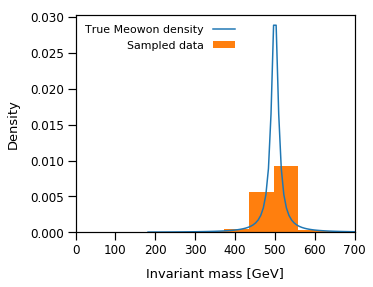

In [36]:
# Visualise your signal distribution
x = numpy.linspace(stats.cauchy.ppf(0.01,M,gamma),
                   stats.cauchy.ppf(0.99,M,gamma), 100)

pyplot.plot(x,stats.cauchy.pdf(x,M,gamma),label='True '+ str(name)+' density')

# Sample some data from the signal
sig = stats.cauchy.rvs(M,gamma,1000)
sigf = sig[(sig > 0) & (sig < M+(20*gamma))]
pyplot.hist(sigf,density=True,label='Sampled data')
pyplot.xlim(0,M+(20*gamma))
pyplot.legend(frameon=False, markerfirst=False)
pyplot.xlabel(r'Invariant mass [GeV]')
pyplot.ylabel(r'Density')

Now that we have our data, let's see if we can infer back our distribution!

The first step is to identify our likelihood function. We shall assume that we are very smart and knew already from literature that the particle has a Cauchy-like distribution. Since each piece of data is independently sampled, we can write

\begin{aligned}
\mathrm{L} ( \theta | x ) = \prod _ { i = 1 } ^ { n } f \left( x _ { i } | \theta \right)  ,
\end{aligned}

where $f \left( x _ { i } | \theta \right)$ is the probability density function for each data point $x_i$ given parameters $\theta$. We can take the logarithm for simplicity:

\begin{aligned} 
\mathrm{l} ( \theta | x ) & = \log \prod _ { i = 1 } ^ { n } f \left( x _ { i } | \theta \right) \\ & = \sum _ { i = 1 } ^ { n } \log f \left( x _ { i } | \theta \right) = \sum _ { i = 1 } ^ { n } \log (\frac { 1 } { \pi } \frac { \gamma } { ( x_i - m ) ^ { 2 } + \gamma ^ { 2 } })
\end{aligned}
for a Cauchy distribution with parameters $m$ and $\gamma$. Using standard packages in SciPy, this isn't difficult to implement.

The Bayesian method has another ingredient: priors. We need to decide what our prior beliefs are about each of the parameters $\theta$ and $\gamma$. For now, we will just use a uniform (constant) prior, which is to signify our apparent ignorance. This is not entirely ignorant however, as a constant prior for $m$ would not be constant for $m^2$, for instance.

*Before we get started, you'll need to install nestle, which is an open-source Python implementation of nested sampling. Running the cell below should do this for you!*

In [124]:
%%bash
pip install nestle

  Running setup.py bdist_wheel for nestle: started
  Running setup.py bdist_wheel for nestle: finished with status 'done'
  Stored in directory: /home/albireo/.cache/pip/wheels/8d/6b/8a/617f2fd643e9003bc64fb4d3be6d59b8fd391c8b0dab23eb61
Successfully built nestle


The next cell performs nested sampling using the likelihood function described above.

Text(0.5,0.98,'log(evidence) = -4504.8')

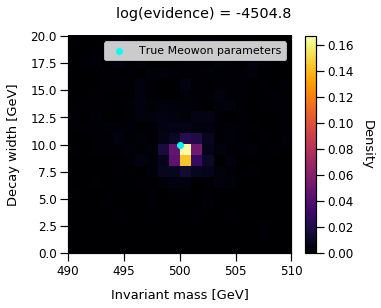

In [47]:
import nestle

# Define log likelihood
# theta = [mass, decay width]
def loglike(theta):
return numpy.log(stats.cauchy.pdf(sigf,theta[0],theta[1])).sum(axis=0)

def priortrans(x):
    return x*(M+(20*gamma))

# Run nested sampling.
result = nestle.sample(loglike, priortrans, 2, method='single')

# Visualise the results!
plot=pyplot.hist2d(result.samples[:,0],result.samples[:,1],
                   range=((M-10,M+10),(gamma-10,gamma+10)),
                   label='Posterior samples', cmap='inferno', bins=20,normed=True)
pyplot.scatter(M,gamma,label='True '+str(name)+' parameters',color=(0,1,1))
cbar = pyplot.colorbar(plot[3])
cbar.ax.set_ylabel('Density', rotation=270,labelpad=20)
pyplot.xlabel(r'Invariant mass [GeV]')
pyplot.ylabel(r'Decay width [GeV]')
pyplot.legend()
pyplot.suptitle('log(evidence) = '+str(-rnd(-result.logz)))

The above plot is a histogram of the posterior samples generated from nested sampling. As you can (hopefully) see, we have a high concentration of samples around the true values.

This was done with a uniform prior -- what happens if we use a 2D Gaussian prior centered on the true values? Let's find out!

Text(0.5,0.98,'log(evidence) = -4495.0')

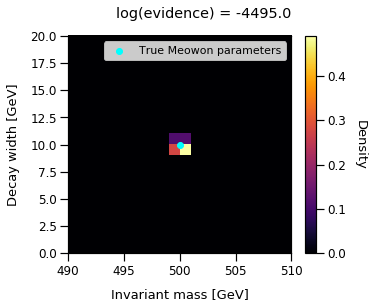

In [48]:
## Do more nested sampling, but change the prior to be Gaussian about the true values
from scipy.special import ndtri

# Invesitgate non-uiform priors
def priortrans(x):
    mu = [M,gamma]
    sigma = [0.1,0.1]
    return mu + sigma * ndtri(x)

# Run nested sampling.
result = nestle.sample(loglike, priortrans, 2, method='single')

# Visualise the results!
plot=pyplot.hist2d(result.samples[:,0],result.samples[:,1],
                   range=((M-10,M+10),(gamma-10,gamma+10)),
                   label='Posterior samples', cmap='inferno', bins=20, normed=True)
pyplot.scatter(M,gamma,label='True '+str(name)+' parameters',color=(0,1,1))
cbar = pyplot.colorbar(plot[3])
cbar.ax.set_ylabel('Density', rotation=270,labelpad=20)
pyplot.xlabel(r'Invariant mass [GeV]')
pyplot.ylabel(r'Decay width [GeV]')
pyplot.legend()
pyplot.suptitle('log(evidence) = '+str(-rnd(-result.logz)))

Here we get much higher density concentrated around the true value, and the samples are a lot less sparse. The plot below illustrates how tightly around the true values the samples are distributed.

If our prior knowledge is good, it seems like we can get a much cleaner distribution.

Text(0.5,0.98,'log(evidence) = -4495.0')

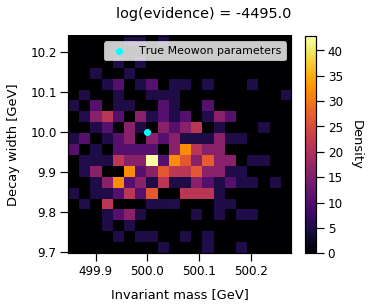

In [49]:
# Zoom in!
plot=pyplot.hist2d(result.samples[:,0],result.samples[:,1],
                   label='Posterior samples', cmap='inferno', bins=20, normed=True)
pyplot.scatter(M,gamma,label='True '+str(name)+' parameters',color=(0,1,1))
cbar = pyplot.colorbar(plot[3])
cbar.ax.set_ylabel('Density', rotation=270,labelpad=20)
pyplot.xlabel(r'Invariant mass [GeV]')
pyplot.ylabel(r'Decay width [GeV]')
pyplot.legend()
pyplot.suptitle('log(evidence) = '+str(-rnd(-result.logz)))

In the real world, we unfortunately don't have perfect signal samples. We usually have some variety of background processes to think about. We can add this artificially to our data sample by creating exponentially distributed background data:

Text(0,0.5,'Frequency')

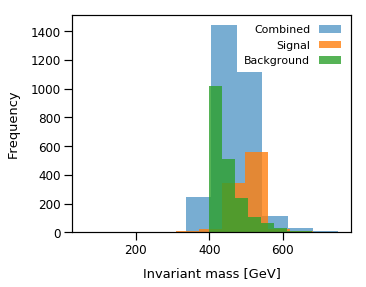

In [89]:
## Create an exponential background distribution

l = 0.02 # Parameter of background distribution

bkg = stats.expon(scale=1/l,loc=M-(10*gamma)).rvs(size=2000)
comb = numpy.concatenate((sigf,bkg))
pyplot.hist(comb,label='Combined',alpha=0.6)
pyplot.hist(sigf,label='Signal', alpha =0.8)
pyplot.xlabel(r'Invariant mass [GeV]')
pyplot.hist(bkg,label='Background',alpha=0.8)
pyplot.legend(frameon=False, markerfirst=False)
pyplot.ylabel(r'Frequency')



Now lets try and perform sampling. We shall use a uniform prior, and have a likelihood function that is a combination of an exponential and cauchy probabilities:

Text(0.5,0.98,'log(evidence) = -13218.0')

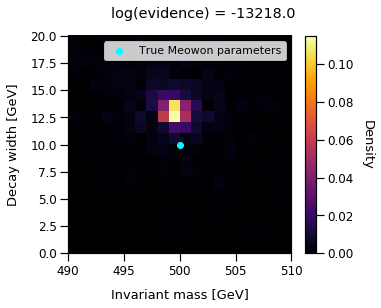

In [116]:
# Define log likelihood
# theta = [mass, decay width]
def loglike(theta):
    return numpy.log(stats.cauchy.pdf(comb,theta[0],theta[1])+stats.expon.pdf(comb,scale=1/theta[2],loc=M-(10*gamma))).sum(axis=0)

def priortrans(x):
    return x*(M+(20*gamma))

# Run nested sampling.
result = nestle.sample(loglike, priortrans, 3, method='single')

# Visualise the results!
plot=pyplot.hist2d(result.samples[:,0],result.samples[:,1],
                   range=((M-10,M+10),(gamma-10,gamma+10)),
                   label='Posterior samples', cmap='inferno', bins=20,normed=True)
pyplot.scatter(M,gamma,label='True '+str(name)+' parameters',color=(0,1,1))
cbar = pyplot.colorbar(plot[3])
cbar.ax.set_ylabel('Density', rotation=270,labelpad=20)
pyplot.xlabel(r'Invariant mass [GeV]')
pyplot.ylabel(r'Decay width [GeV]')
pyplot.legend()
pyplot.suptitle('log(evidence) = '+str(-rnd(-result.logz)))

Here we don't do so well. The evidence value also tells us this, being a logarithmic order of magnitude smaller than it was for the previous examples. This could be due to a number of reasons, such as a bad modelling of the likelihood, or perhaps a more informative prior is needed. This was just one level of realism; many more could be added, which is why a thorough treatment of the likelihood and any potential biases is required.

Hope you enjoyed this brief tutorial! Further reading can be found below.

- John Skilling et al. Nested sampling for general Bayesian computation.Bayesian analysis, 1(4):833–859,2006. http://www.mrao.cam.ac.uk/~steve/maxent2009/images/skilling.pdf
- S Sivia, D & Skilling, J. (2006). Data Analysis A Bayesian Tutorial. 
- http://kylebarbary.com/nestle/
- http://www.mrao.cam.ac.uk/~steve/maxent2009/images/rant.pdf
